In [31]:
import json,os,jieba
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

In [5]:
queryroot="./annot"
tok2id_p="./idftab/tok2id.json"
idftab_p="./idftab/idftab.json"
query_p="query.json"

def create_df(annot_pos): 
    df = pd.DataFrame({'score': np.array(annot_pos)}) 
    return df 

dirs=os.listdir(queryroot)
corpus_p="./corpus_q_jieba.json"
with open(corpus_p,"r",encoding="utf-8") as fr:
    qcorpus=json.load(fr)
with open(tok2id_p,"r",encoding="utf-8") as fr:
    tok2idtab=json.load(fr)
with open(idftab_p,"r",encoding="utf-8") as fr:
    idftab=json.load(fr)

# 如果去除停用词的话
stopword_p="stopword.txt"
with open(stopword_p, 'r',encoding="utf-8") as g:
    words = g.readlines() #stop words
stopwords = [i.strip() for i in words]
qdict={}
with open(query_p,'r',encoding="utf-8") as f:
    lines = f.readlines()
    for line in lines:
        entry=eval(line)
        rid=entry["ridx"]
        qdict[rid]=entry["q"]

puncset={'”','“','.','（','）','-','：','、','㈠', '［', '×', '］', '／', '㈥', '.', '㈢', '《', '＊', '，', '㈡', '。', '》', '；', '㈤', '㈣', '？',"／"}

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\PC\AppData\Local\Temp\jieba.cache
Loading model cost 0.768 seconds.
Prefix dict has been built successfully.


(107,)
Sum rate:0.19064670835978603,Sum rate nostop words:0.1775787772367657
query length:444.58878504672896,query length no stop words:405.1121495327103
Annot length:72.14018691588785,Annot length no stop words:60.77570093457944


<Axes: >

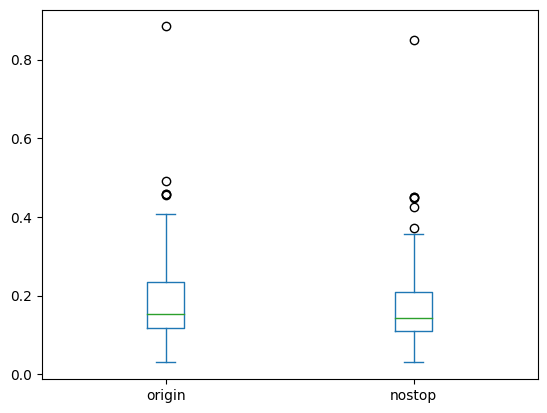

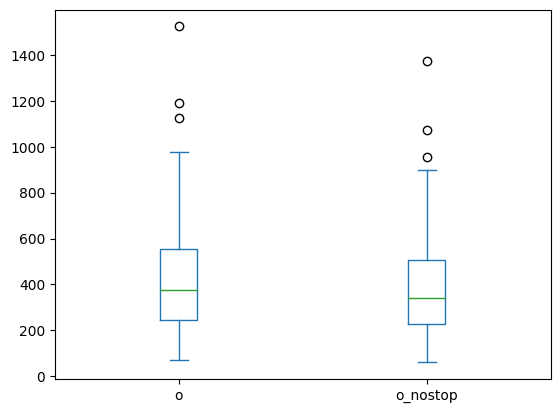

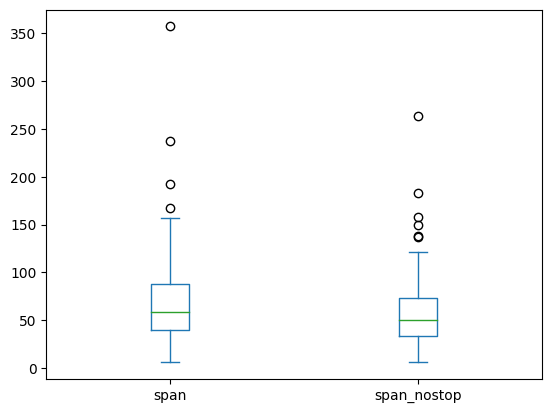

In [6]:
q_nostop_r={}
q_origin_r={}

q_origin={}
q_spanorigin={}

q_nostop={}
q_spannostop={}


for name in dirs:
    # print(name)
    dir=os.path.join(queryroot,name)
    with open(dir,"r",encoding="utf-8") as fr:
        items=json.load(fr)
        annotation=items["html"]
        qid=items["task_id"]
        original_query=qdict[qid]
        result=annotation.split("<span>")
        spanls=[]
        spanwordls=[]

        spancharleng=0
        spancharnostopleng=0

        for item in result[1:]:
            itemls=item.split("</span>")
            spancharleng+=len(itemls[0]) # have stop words
            spanls.append(itemls[0]) # 只有itemls[0]落于<span> </span>之间。
            tmp= jieba.cut(itemls[0], cut_all=False)
            tem = " ".join(tmp).split() 

            # 去除标注中的标点
            for ws in tem:
                if ws not in puncset and ws not in stopwords:
                    spancharnostopleng+=len(ws) #标注的no stop words
                    spanwordls.append(ws)

        charnostopleng=0
        for word in qcorpus[str(qid)]:
            charnostopleng+=len(word) #原始query no stop words

        q_origin_r[qid]=spancharleng/len(original_query) # 标注/query,含停用词
        q_nostop_r[qid]=spancharnostopleng/charnostopleng 

        q_origin[qid]=len(original_query)
        q_spanorigin[qid]=spancharleng

        q_nostop[qid]=charnostopleng
        q_spannostop[qid]=spancharnostopleng
        

qorigin=np.array(list(q_origin.values()))
qnostop=np.array(list(q_nostop.values()))
print(qorigin.shape)

qspanorigin=np.array(list(q_spanorigin.values()))
qspannostop=np.array(list(q_spannostop.values()))

qorigin_r=np.array(list(q_origin_r.values()))
qnostop_r=np.array(list(q_nostop_r.values()))

# print(qorigin)
# print(qnostop) # 当然，压缩率可能和原本的长度有关系，但似乎不重要;

# ratio;
qdata=np.stack((qorigin_r,qnostop_r))
print("Sum rate:{},Sum rate nostop words:{}".format(np.average(qorigin_r),np.average(qnostop_r)))
qdata=np.transpose(qdata)
# print(qdata.shape)
df6 = pd.DataFrame(data = qdata, columns=['origin','nostop']) 
df6.plot.box()
## get average

# total length
qdata=np.stack((qorigin,qnostop))
qdata=np.transpose(qdata)
# print(qdata.shape)
print("query length:{},query length no stop words:{}".format(np.average(qorigin),np.average(qnostop)))
df7 = pd.DataFrame(data = qdata, columns=['o','o_nostop']) 
df7.plot.box()     

qdata=np.stack((qspanorigin,qspannostop))
qdata=np.transpose(qdata)
# print(qdata.shape)
print("Annot length:{},Annot length no stop words:{}".format(np.average(qspanorigin),np.average(qspannostop)))
df8 = pd.DataFrame(data = qdata, columns=["span","span_nostop"]) 
df8.plot.box()     


In [7]:
def cutbins(values,bins,labels):
    resls=[0 for _ in range(len(labels))]
    for v in values:
        for idx in list(range(len(bins)))[:-1]:
            low=bins[idx]
            uper=bins[idx+1]
            if v>= low and v<uper:
                resls[idx]+=1
    return resls

def ncutbins(values,bins,labels):
    resls=[0 for _ in range(len(labels))]
    for v in values:
        for idx in list(range(len(bins)))[:-1]:
            low=bins[idx]
            uper=bins[idx+1]
            if v>= low and v<uper:
                resls[idx]+=1
    nresls=[]
    for v in resls:
        nresls.append(v/len(values)) #排名列表
    return nresls



In [8]:
def generate(xls,yls):
    xnew=[]
    ynew=[]
    for idx,x in enumerate(xls):
        if idx==0 or idx==len(xls)-1:
            xnew.append(x)
        else:
            for i in range(2):
                xnew.append(x)
    for idx,y in enumerate(yls):
        for i in range(2):
            ynew.append(y)
    return xnew,ynew


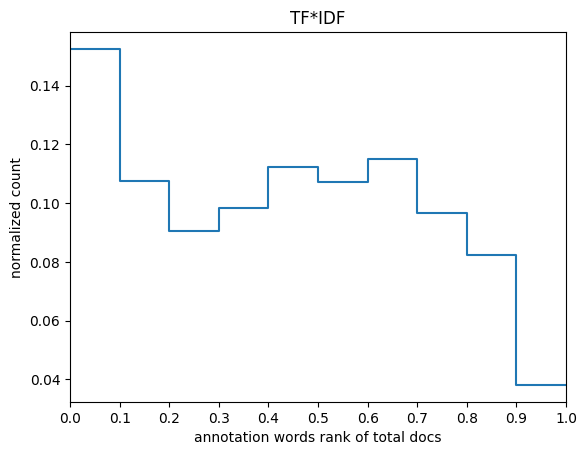

In [9]:
# bins = [0,0.2,0.4,0.6,0.8,1]
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
labels = [str(v) for v in bins][1:]
accumulate_rels=[0 for i in range(len(labels))]

totaltf=[]
for name in dirs:
    # print(name)
    dir=os.path.join(queryroot,name)

    with open(dir,"r",encoding="utf-8") as fr:
        items=json.load(fr)
        annotation=items["html"]
        qid=items["task_id"]
        result=annotation.split("<span>")
        spanls=[]
        spanwordls=[]
        for item in result[1:]:
            itemls=item.split("</span>")
            spanls.append(itemls[0])
            tmp= jieba.cut(itemls[0], cut_all=False) 
            tem = " ".join(tmp).split()
            # 去除标注中的标点
            for ws in tem:
                if ws not in puncset:
                    spanwordls.append(ws)
        spanwordset=set(spanwordls) #注意新分的词语不一定在原本的词语列表中
        # print(len(spanwordset))
        wordls=qcorpus[str(qid)] #wordls是完整的，并没有做停用词处理;但是没有标点符号
        ws=Counter(wordls)
        tfidfdic={}
        for tok in ws:
            if tok not in tok2idtab:
                continue
            tokid=tok2idtab[tok]
            idf=idftab[str(tokid)]
            tf=ws[tok] 
            tfidfdic[tok]=tf*idf
        rankres=sorted(tfidfdic.items(),key=lambda x:x[1],reverse=True) #对于原始词语的排序
        rankdic={}
        for idx,entry in enumerate(rankres):
            rankdic[entry[0]]=idx # idx为序列的顺序;
        annot_pos=[]
        for tok in spanwordset:
            if tok not in rankdic:
                continue
            annot_pos.append(rankdic[tok]/len(rankres))
        totaltf.extend(annot_pos)
        # 求得位置百分比,0.2,0.4,0.6,...,0.8,1.0
        resls=ncutbins(annot_pos,bins,labels)
        # cutbins会受到文件长度影响;
        # ncutbins会受到短标注和不均匀分布的影响;
        # print(len(annot_pos))
        # print(len(annotation))
        df=create_df(annot_pos) 
        df.head()
        df['grade'] = pd.cut(x = df['score'], 
                            bins = bins, 
                            labels = labels, 
                            include_lowest = True)
        final_res=df.grade.value_counts()
        # print(final_res)
        for idx,v in enumerate(resls):
            accumulate_rels[idx]+=v

# print(accumulate_rels)

## 1. 标注本身的TF-IDF值

# xpoints = np.array([0,0.2,0.2,0.4,0.4,0.6,0.6,0.8,0.8,1])
# ypoints = np.array([25.386,25.386, 18.427,18.427, 21.43,21.43, 25.33, 25.33,16.43,16.43])
accumulate_rels=np.array(accumulate_rels)
tfidf=accumulate_rels/np.sum(accumulate_rels)

xpoints,ytfidf=generate(bins,tfidf)

#设置刻度范围
fig=plt.figure(num=1)
ax=fig.add_subplot(111)
ax.plot(xpoints, ytfidf)
ax.set_xlim(0,1)#x轴从1到7.1
ax.set_title("TF*IDF")
ax.set_xlabel("annotation words rank of total docs")
ax.set_ylabel("normalized count")

ax.set_xticks(np.linspace(0,1,len(bins)))

plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_2704\1961368196.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(totaltf, shade=True, cut=0, color='y')


<Axes: ylabel='Density'>

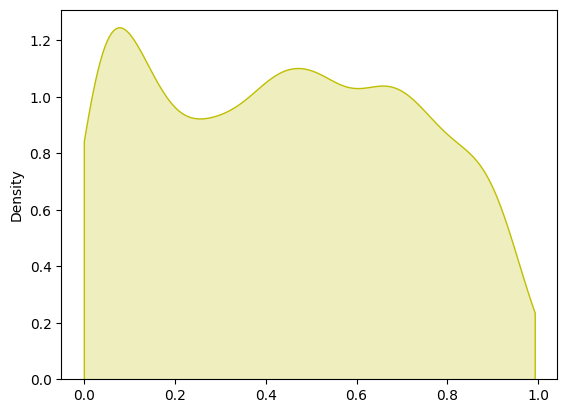

In [10]:
sns.kdeplot(totaltf, shade=True, cut=0, color='y')

In [11]:
def generate(xls,yls):
    xnew=[]
    ynew=[]
    for idx,x in enumerate(xls):
        if idx==0 or idx==len(xls)-1:
            xnew.append(x)
        else:
            for i in range(2):
                xnew.append(x)
    for idx,y in enumerate(yls):
        for i in range(2):
            ynew.append(y)
    return xnew,ynew


# 1. basic analysis

## TF*IDF值

1. 可见，标注为与案件诉讼罪名有直接证据的区域，并非是有高TF-IDF（熵）概率的词语，且事实上有不少的TF-IDF值处于中间偏后的结果；

# IDF值（不去除停用词）

In [12]:
# bins = [0,0.2,0.4,0.6,0.8,1]
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
labels = [str(v) for v in bins][1:]
accumulate_rels=[0 for i in range(len(labels))]
totalidf=[]

for name in dirs:
    # print(name)
    dir=os.path.join(queryroot,name)

    with open(dir,"r",encoding="utf-8") as fr:
        items=json.load(fr)
        annotation=items["html"]
        qid=items["task_id"]
        result=annotation.split("<span>")
        spanls=[]
        spanwordls=[]
        for item in result[1:]:
            itemls=item.split("</span>")
            spanls.append(itemls[0])
            tmp= jieba.cut(itemls[0], cut_all=False) 
            tem = " ".join(tmp).split()
            # 去除标注中的标点
            for ws in tem:
                if ws not in puncset:
                    spanwordls.append(ws)
        spanwordset=set(spanwordls) #注意新分的词语不一定在原本的词语列表中
        # print(len(spanwordset))
        wordls=qcorpus[str(qid)] #wordls是完整的，并没有做停用词处理;但是没有标点符号
        ws=Counter(wordls)
        tfidfdic={}
        for tok in ws:
            if tok not in tok2idtab:
                continue
            tokid=tok2idtab[tok]
            idf=idftab[str(tokid)]
            tf=ws[tok] 
            tfidfdic[tok]=idf
        rankres=sorted(tfidfdic.items(),key=lambda x:x[1],reverse=True) #对于原始词语的排序
        rankdic={}
        for idx,entry in enumerate(rankres):
            rankdic[entry[0]]=idx
        annot_pos=[]
        for tok in spanwordset:
            if tok not in rankdic:
                continue
            annot_pos.append(rankdic[tok]/len(rankres))
            totalidf.extend(annot_pos)
        # 求得位置百分比,0.2,0.4,0.6,...,0.8,1.0
        resls=ncutbins(annot_pos,bins,labels)
        # cutbins会受到文件长度影响;
        # ncutbins会受到短标注和不均匀分布的影响;
        # print(len(annot_pos))
        # print(len(annotation))
        df=create_df(annot_pos) 
        df.head()
        df['grade'] = pd.cut(x = df['score'], 
                            bins = bins, 
                            labels = labels, 
                            include_lowest = True)
        final_res=df.grade.value_counts()
        # print(final_res)
        for idx,v in enumerate(resls):
            accumulate_rels[idx]+=v
print(accumulate_rels)
accumulate_rels=np.array(accumulate_rels)
idfbins=accumulate_rels/np.sum(accumulate_rels)


[6.879920199494454, 9.723074005251874, 11.34526913524197, 12.61031158075189, 13.498999845516801, 12.605167346778124, 13.488912546696033, 10.593907542152813, 10.73425750811871, 5.52018028999729]


C:\Users\PC\AppData\Local\Temp\ipykernel_2704\2444575878.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(totalidf, shade=True, cut=0, color='y')


<Axes: ylabel='Density'>

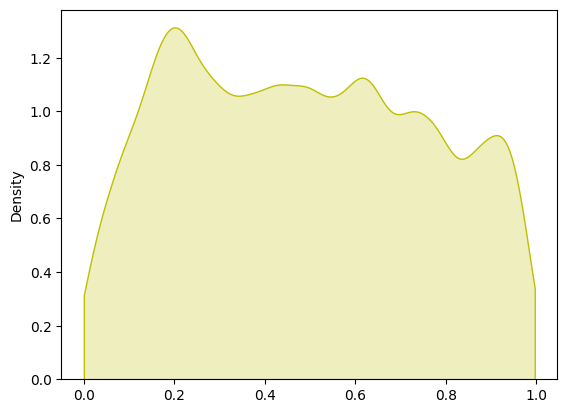

In [13]:
sns.kdeplot(totalidf, shade=True, cut=0, color='y')

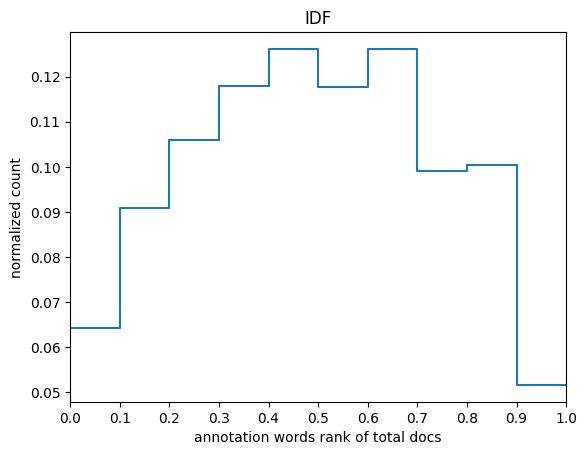

In [14]:
accumulate_rels=np.array(accumulate_rels)
idfbins=accumulate_rels/np.sum(accumulate_rels)
xpoints,yidfbins=generate(bins,idfbins)
#设置刻度范围
fig=plt.figure(num=1)
ax=fig.add_subplot(111)
ax.plot(xpoints, yidfbins)
ax.set_xlim(0,1)#x轴从1到7.1

ax.set_xticks(np.linspace(0,1,len(bins)))
ax.set_title("IDF")
ax.set_xlabel("annotation words rank of total docs")
ax.set_ylabel("normalized count")
plt.show()

2. 标注中IDF值较高的内容，也就是信息熵较大的词语，未必起到作用，而其中处在中间靠后的词语，却被认为是重要的；
3. 一个词语本身信息熵高，并不一定好，而TF-iDF高，很有可能是个有提示意义的词语；且IDF、TF-IDF值处于中后端（0.5-0.8）的部分其实比较重要，长距离的共现信息是重要的。即高IDF值的词语本身多次出现，或者一组不是很高的IDF值，TF-IDF值的词语共现，对案例匹配有重要意义，可以解释BM25和QL这种基于词语的匹配模型效果不错，因为在较长的法律文本（尤其是刑事判决文书中，这一点当初在标注和检查的时候，律师和我说可能研究民事文书更有意义一些，因为刑事文书的很多量刑本身其实比较严格，因此相似案件的行为在词语上就表现的非常像），很多具有固定用法的词语，并不稀有，但是他们在长距离上有稳定的共现关系；

# 3.TF值（不去除停用词）

['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']


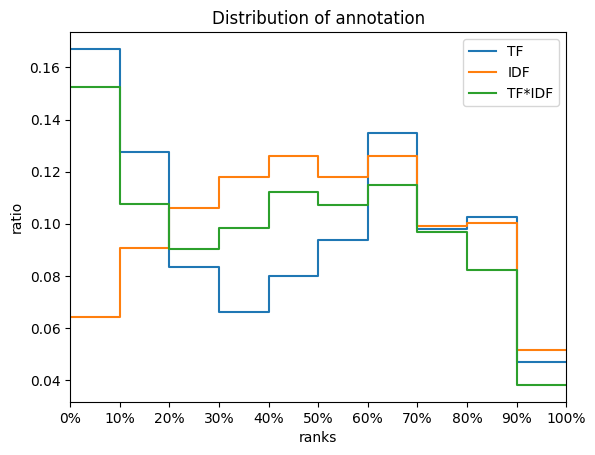

In [17]:
# TF value
xpoints,ytfbins=generate(bins,tfbins)

# IDF value

xpoints,yidfbins=generate(bins,idfbins)

# TF*IDF
xpoints,ytfidf=generate(bins,tfidf)
#设置刻度范围

#设置刻度范围
plt.plot(xpoints, ytfbins,label="TF")
plt.plot(xpoints, yidfbins,label="IDF",)
plt.plot(xpoints, ytfidf,label="TF*IDF")


plt.xlim(0,1)#x轴从1到7.1
plt.title("Distribution of annotation")
plt.xlabel("ranks")
plt.ylabel("ratio")

xsticks=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))]
print(xsticks)
plt.xticks(np.linspace(0,1,len(bins)),xsticks)

plt.legend()
plt.show()


accumulate_rels=np.array(accumulate_rels)
tfbins=accumulate_rels/np.sum(accumulate_rels)
xpoints,ytfbins=generate(bins,tfbins)
#设置刻度范围
fig=plt.figure(num=1)
ax=fig.add_subplot(111)
ax.plot(xpoints, ytfbins)
ax.set_xlim(0,1)#x轴从1到7.1

ax.set_xticks(np.linspace(0,1,len(bins)))
ax.set_title("TF")
ax.set_xlabel("annotation words rank of total docs")
ax.set_ylabel("normalized count")
plt.show()

# 去除停用词

[8.659708998941177, 9.02690650648472, 7.35657316567482, 9.639293587326087, 14.055294539008443, 14.13169062913351, 15.141073322329028, 12.83092410649213, 11.084060135475195, 5.074475009134882]


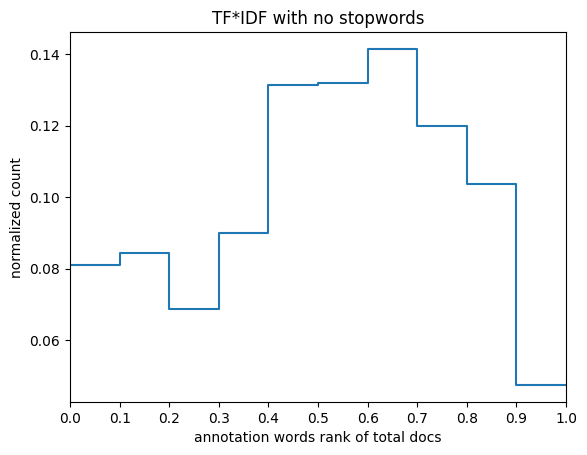

In [18]:
# bins = [0,0.2,0.4,0.6,0.8,1]
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
labels = [str(v) for v in bins][1:]
accumulate_rels=[0 for i in range(len(labels))]
for name in dirs:
    # print(name)
    dir=os.path.join(queryroot,name)

    with open(dir,"r",encoding="utf-8") as fr:
        items=json.load(fr)
        annotation=items["html"]
        qid=items["task_id"]
        result=annotation.split("<span>")
        spanls=[]
        spanwordls=[]
        for item in result[1:]:
            itemls=item.split("</span>")
            spanls.append(itemls[0])
            tmp= jieba.cut(itemls[0], cut_all=False) 
            tem = " ".join(tmp).split()
            # 去除标注中的标点
            for ws in tem:
                if ws not in puncset:
                    spanwordls.append(ws)
        spanwordset=set(spanwordls) #注意新分的词语不一定在原本的词语列表中
        # print(len(spanwordset))
        wordls=qcorpus[str(qid)] #wordls是完整的，并没有做停用词处理;但是没有标点符号
        ws=Counter(wordls)
        tfidfdic={}
        for tok in ws:
            if tok not in tok2idtab:
                continue
            tokid=tok2idtab[tok]
            idf=idftab[str(tokid)]
            tf=ws[tok] 
            tfidfdic[tok]=tf*idf
        rankres=sorted(tfidfdic.items(),key=lambda x:x[1],reverse=True) #对于原始词语的排序
        rankdic={}
        for idx,entry in enumerate(rankres):
            rankdic[entry[0]]=idx
        annot_pos=[]
        for tok in spanwordset:
            if tok not in rankdic:
                continue
            if tok in stopwords:
                continue
            annot_pos.append(rankdic[tok]/len(rankres))
        # 求得位置百分比,0.2,0.4,0.6,...,0.8,1.0
        resls=ncutbins(annot_pos,bins,labels)
        # cutbins会受到文件长度影响;
        # ncutbins会受到短标注和不均匀分布的影响;
        # print(len(annot_pos))
        # print(len(annotation))
        df=create_df(annot_pos) 
        df.head()
        df['grade'] = pd.cut(x = df['score'], 
                            bins = bins, 
                            labels = labels, 
                            include_lowest = True)
        final_res=df.grade.value_counts()
        # print(final_res)
        for idx,v in enumerate(resls):
            accumulate_rels[idx]+=v
print(accumulate_rels)
accumulate_rels=np.array(accumulate_rels)
tfidfnostop=accumulate_rels/np.sum(accumulate_rels)

xpoints,ytfidfnostop=generate(bins,tfidfnostop)
#设置刻度范围
fig=plt.figure(num=1)
ax=fig.add_subplot(111)
ax.plot(xpoints, ytfidfnostop)
ax.set_xlim(0,1)#x轴从1到7.1

ax.set_xticks(np.linspace(0,1,len(bins)))
ax.set_title("TF*IDF with no stopwords")
ax.set_xlabel("annotation words rank of total docs")
ax.set_ylabel("normalized count")
plt.show()

[3.874362044720653, 3.69008288746866, 4.864931083847923, 12.075846815981206, 16.711728295204395, 15.733030882510928, 16.743760550319898, 13.147054539513961, 13.25307857419884, 6.906124326233526]


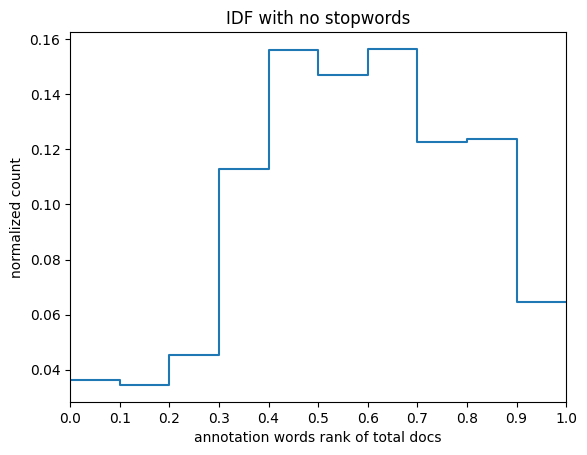

In [19]:
# bins = [0,0.2,0.4,0.6,0.8,1]
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
labels = [str(v) for v in bins][1:]
accumulate_rels=[0 for i in range(len(labels))]
for name in dirs:
    # print(name)
    dir=os.path.join(queryroot,name)

    with open(dir,"r",encoding="utf-8") as fr:
        items=json.load(fr)
        annotation=items["html"]
        qid=items["task_id"]
        result=annotation.split("<span>")
        spanls=[]
        spanwordls=[]
        for item in result[1:]:
            itemls=item.split("</span>")
            spanls.append(itemls[0])
            tmp= jieba.cut(itemls[0], cut_all=False) 
            tem = " ".join(tmp).split()
            # 去除标注中的标点
            for ws in tem:
                if ws not in puncset:
                    spanwordls.append(ws)
        spanwordset=set(spanwordls) #注意新分的词语不一定在原本的词语列表中
        # print(len(spanwordset))
        wordls=qcorpus[str(qid)] #wordls是完整的，并没有做停用词处理;但是没有标点符号
        ws=Counter(wordls)
        tfidfdic={}
        for tok in ws:
            if tok not in tok2idtab:
                continue
            tokid=tok2idtab[tok]
            idf=idftab[str(tokid)]
            tf=ws[tok] 
            tfidfdic[tok]=idf
        rankres=sorted(tfidfdic.items(),key=lambda x:x[1],reverse=True) #对于原始词语的排序
        rankdic={}
        for idx,entry in enumerate(rankres):
            rankdic[entry[0]]=idx
        annot_pos=[]
        for tok in spanwordset:
            if tok not in rankdic:
                continue
            if tok in stopwords:
                continue
            annot_pos.append(rankdic[tok]/len(rankres))
        # 求得位置百分比,0.2,0.4,0.6,...,0.8,1.0
        resls=ncutbins(annot_pos,bins,labels)
        # cutbins会受到文件长度影响;
        # ncutbins会受到短标注和不均匀分布的影响;
        # print(len(annot_pos))
        # print(len(annotation))
        df=create_df(annot_pos) 
        df.head()
        df['grade'] = pd.cut(x = df['score'], 
                            bins = bins, 
                            labels = labels, 
                            include_lowest = True)
        final_res=df.grade.value_counts()
        # print(final_res)
        for idx,v in enumerate(resls):
            accumulate_rels[idx]+=v
print(accumulate_rels)
accumulate_rels=np.array(accumulate_rels)
idfnostop=accumulate_rels/np.sum(accumulate_rels)

xpoints,yidfnostop=generate(bins,idfnostop)
#设置刻度范围
fig=plt.figure(num=1)
ax=fig.add_subplot(111)
ax.plot(xpoints, yidfnostop)
ax.set_xlim(0,1)#x轴从1到7.1

ax.set_xticks(np.linspace(0,1,len(bins)))
ax.set_title("IDF with no stopwords")
ax.set_xlabel("annotation words rank of total docs")
ax.set_ylabel("normalized count")

plt.show()

[15.11425750728881, 12.020252726268556, 8.911192974228731, 7.3714067024063175, 8.965510566810373, 10.818321099725413, 15.147041473826118, 10.986637188326402, 12.15897311229139, 5.506406648827882]


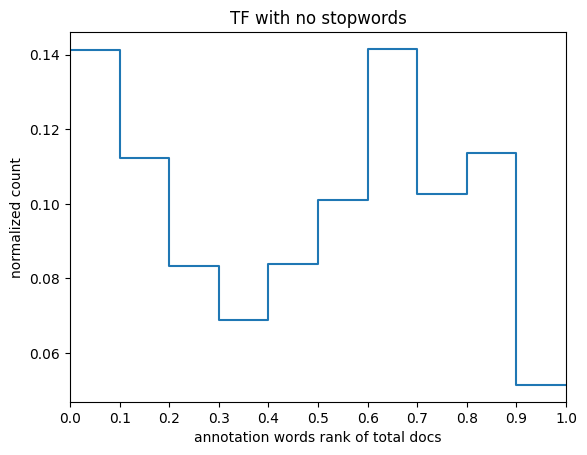

In [20]:
# bins = [0,0.2,0.4,0.6,0.8,1]
bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
labels = [str(v) for v in bins][1:]
accumulate_rels=[0 for i in range(len(labels))]
for name in dirs:
    # print(name)
    dir=os.path.join(queryroot,name)

    with open(dir,"r",encoding="utf-8") as fr:
        items=json.load(fr)
        annotation=items["html"]
        qid=items["task_id"]
        result=annotation.split("<span>")
        spanls=[]
        spanwordls=[]
        for item in result[1:]:
            itemls=item.split("</span>")
            spanls.append(itemls[0])
            tmp= jieba.cut(itemls[0], cut_all=False) 
            tem = " ".join(tmp).split()
            # 去除标注中的标点
            for ws in tem:
                if ws not in puncset:
                    spanwordls.append(ws)
        spanwordset=set(spanwordls) #注意新分的词语不一定在原本的词语列表中
        # print(len(spanwordset))
        wordls=qcorpus[str(qid)] #wordls是完整的，并没有做停用词处理;但是没有标点符号
        ws=Counter(wordls)
        tfidfdic={}
        for tok in ws:
            if tok not in tok2idtab:
                continue
            tokid=tok2idtab[tok]
            idf=idftab[str(tokid)]
            tf=ws[tok] 
            tfidfdic[tok]=tf
        rankres=sorted(tfidfdic.items(),key=lambda x:x[1],reverse=True) #对于原始词语的排序
        rankdic={}
        for idx,entry in enumerate(rankres):
            rankdic[entry[0]]=idx
        annot_pos=[]
        for tok in spanwordset:
            if tok not in rankdic:
                continue
            if tok in stopwords:
                continue
            annot_pos.append(rankdic[tok]/len(rankres))
        # 求得位置百分比,0.2,0.4,0.6,...,0.8,1.0
        resls=ncutbins(annot_pos,bins,labels)
        # cutbins会受到文件长度影响;
        # ncutbins会受到短标注和不均匀分布的影响;
        # print(len(annot_pos))
        # print(len(annotation))
        df=create_df(annot_pos) 
        df.head()
        df['grade'] = pd.cut(x = df['score'], 
                            bins = bins, 
                            labels = labels, 
                            include_lowest = True)
        final_res=df.grade.value_counts()
        # print(final_res)
        for idx,v in enumerate(resls):
            accumulate_rels[idx]+=v
print(accumulate_rels)
accumulate_rels=np.array(accumulate_rels)
tfnostop=accumulate_rels/np.sum(accumulate_rels)
xpoints,ytfnostop=generate(bins,tfnostop)
#设置刻度范围
fig=plt.figure(num=1)
ax=fig.add_subplot(111)
ax.plot(xpoints, ytfnostop)
ax.set_xlim(0,1)#x轴从1到7.1

ax.set_xticks(np.linspace(0,1,len(bins)))
ax.set_title("TF with no stopwords")
ax.set_xlabel("annotation words rank of total docs")
ax.set_ylabel("normalized count")

plt.show()

['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']


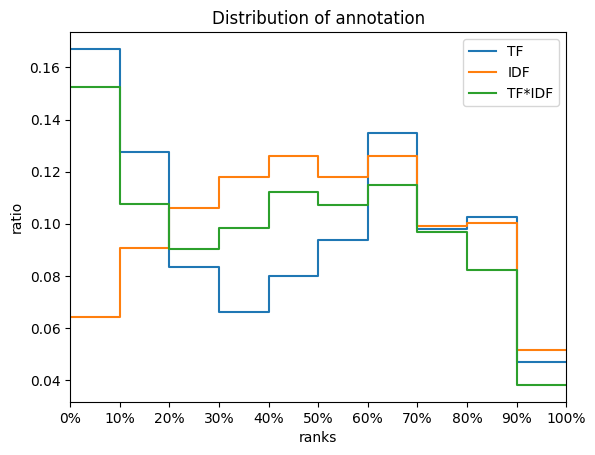

In [21]:
# TF value
xpoints,ytfbins=generate(bins,tfbins)

# IDF value

xpoints,yidfbins=generate(bins,idfbins)

# TF*IDF
xpoints,ytfidf=generate(bins,tfidf)
#设置刻度范围

#设置刻度范围
plt.plot(xpoints, ytfbins,label="TF")
plt.plot(xpoints, yidfbins,label="IDF",)
plt.plot(xpoints, ytfidf,label="TF*IDF")


plt.xlim(0,1)#x轴从1到7.1
plt.title("Distribution of annotation")
plt.xlabel("ranks")
plt.ylabel("ratio")

xsticks=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))]
print(xsticks)
plt.xticks(np.linspace(0,1,len(bins)),xsticks)

plt.legend()
plt.show()


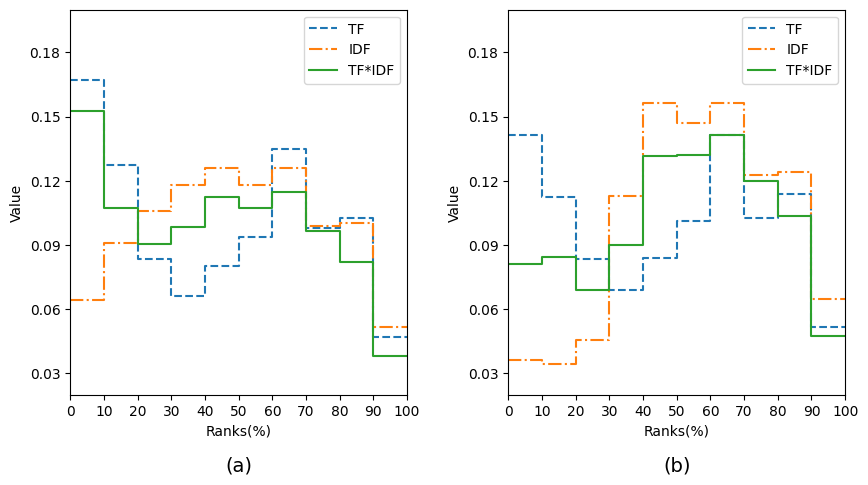

In [34]:

# print(np.sum(heattfs,axis=1)/np.sum(heatcounts,axis=1))
# 一、tfvalues

#设置刻度范围
fig=plt.figure(num=1,figsize=(10,5))
ax=plt.subplot(121)

ax.plot(xpoints, ytfbins,label="TF",linestyle='--')
ax.plot(xpoints, yidfbins,label="IDF",linestyle='-.')
ax.plot(xpoints, ytfidf,label="TF*IDF",linestyle='-')

ax.set_xlim(0,1)#x轴从1到7.1
ax.set_ylim(0.02, 0.2)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.03))
ax.set_title("(a)", y=-0.22, fontsize=14)
# ax.set_title("Distribution of annotation")
ax.set_xlabel("Ranks(%)")
ax.set_ylabel("Value")
xsticks=[str(int(x)) for x in np.linspace(0,100,len(bins))]
# xsticks=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))]
ax.set_xticks(np.linspace(0,1,len(bins)),xsticks)
plt.legend()

# 二、idf value

#设置刻度范围
ax=plt.subplot(122)
ax.plot(xpoints, ytfnostop,label="TF",linestyle='--')
ax.plot(xpoints, yidfnostop,label="IDF",linestyle='-.')
ax.plot(xpoints, ytfidfnostop,label="TF*IDF",linestyle='-')
ax.set_xlim(0,1)#x轴从1到7.1
ax.set_ylim(0.02, 0.2)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.03))
# ax.set_title("Distribution of annotation with no stopswords")
ax.set_xlabel("Ranks(%)")
ax.set_ylabel("Value")

ax.set_title("(b)", y=-0.22, fontsize=14)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=0.3) # wspace 左右距离;hspace 上下距离

plt.legend()
# xsticks=['{:.0%}'.format(x) for x in np.linspace(0,1,len(bins))]
xsticks=[str(int(x)) for x in np.linspace(0,100,len(bins))]
ax.set_xticks(np.linspace(0,1,len(bins)),xsticks)
